# Тема работы: Предсказание съедобный гриб или нет (задача бинарной классификации).
Источник данных: https://www.kaggle.com/uciml/mushroom-classification

Описание данных: датасет содержит данные о 23 различных категориальных признаках 8124 экземпляров грибов, в том числе и бинарный категориальный признак - можно гриб есть или нет.




In [ ]:
#монтируем наш гуглдрайв к файловой системе виртуальной машины, которую гугл любезно нам предоставил
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [ ]:
#добавим путь к папке с проектов в системные переменные
import sys
sys.path.append('/content/gdrive/My Drive/грибы')

In [ ]:
#импортируем библиотеки, часть из них возможно не понадоятся
import math #математические функции
import csv  #для чтения csv-файлов
import numpy as np  #для работы с матрицами
import pandas as pd #для работы с таблицами
from tensorflow.keras import Input, Model, Sequential, regularizers, optimizers, models
from tensorflow.keras.layers import concatenate,TimeDistributed, Concatenate, GRU, Activation, Dropout, Flatten,SeparableConv1D, Dense, SimpleRNN, LSTM, Conv1D, Reshape,MaxPooling1D, Conv2D, Reshape,MaxPooling2D, Permute,Bidirectional, BatchNormalization, DepthwiseConv2D, GlobalMaxPooling2D
from tensorflow.keras.utils import plot_model #отрисовка структуры модели
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping,Callback
from tensorflow.keras.models import model_from_json #загрузка модели из файлов json и h5
import matplotlib.pyplot as plt #отрисовка графиков
import tensorflow.keras.backend as K #для кастомизации функции потерь
import random #для перемешивания данных

In [ ]:
#проверяем версию tensorflow, если выше чем 2.0.0 то хорошо, если 2.3.0 то отлично
import tensorflow as tf
tf.__version__

'2.3.0'

In [ ]:
#создаем переменные для пути к датасету и для папки проекта
data_path='/content/gdrive/My Drive/грибы/mushrooms.csv'
folder='/content/gdrive/My Drive/грибы'

# Подготовка данных (часть 1)

In [ ]:
#считываем данные из файла
df = pd.read_csv(data_path)

In [ ]:
#проверить сколько строк и столбцов в таблице с данными
df.shape

(8124, 23)

In [ ]:
#проверяем сколько строк удалиться если удалить строки с NaN 
df2=df.dropna(axis='index', how='any')
df2.shape
#количество строк не изменилось, значит у нас нет строк с NaN

(8124, 23)

In [ ]:
#убедимся что все данные категориальные
df.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,stalk-root,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,e,e,s,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,e,c,s,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,e,c,s,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,e,e,s,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,t,e,s,s,w,w,p,w,o,e,n,a,g


In [ ]:
#посмотрим сколько уникальных значений для каждого столбца 
df.nunique()

class                        2
cap-shape                    6
cap-surface                  4
cap-color                   10
bruises                      2
odor                         9
gill-attachment              2
gill-spacing                 2
gill-size                    2
gill-color                  12
stalk-shape                  2
stalk-root                   5
stalk-surface-above-ring     4
stalk-surface-below-ring     4
stalk-color-above-ring       9
stalk-color-below-ring       9
veil-type                    1
veil-color                   4
ring-number                  3
ring-type                    5
spore-print-color            9
population                   6
habitat                      7
dtype: int64

Данные у нас категориальные во всех столбцах, во многих из них значения не бинарные. А еще у нас все данные в виде букв, а компьютерам как известно цифры больше нравятся.
Поэтому нам нужно провести кодирование, но если мы применим метод "One-hot encoding" то у нас количество столбцов в таблице будет более 100. Предлагаю не мучить сервера гугла таким количеством столбцов и попробовать применить LabelEncoder из Sklearn. Если точность не будет нас устраивать, то придется "One-hot encod-ить".

In [ ]:
from sklearn.preprocessing import LabelEncoder

for col in df.columns:    
    # применяем LabelEncoder
    le = LabelEncoder()
    le.fit(df[col].unique())


    # выводим соответствие значений "было-стало"
    print('\n' + col + ':')
    for val in df[col].unique():
        print(val, int(le.transform([val])))

    df[col] = le.transform(df[col])



class:
p 1
e 0

cap-shape:
x 5
b 0
s 4
f 2
k 3
c 1

cap-surface:
s 2
y 3
f 0
g 1

cap-color:
n 4
y 9
w 8
g 3
e 2
p 5
b 0
u 7
c 1
r 6

bruises:
t 1
f 0

odor:
p 6
a 0
l 3
n 5
f 2
c 1
y 8
s 7
m 4

gill-attachment:
f 1
a 0

gill-spacing:
c 0
w 1

gill-size:
n 1
b 0

gill-color:
k 4
n 5
g 2
p 7
w 10
h 3
u 9
e 1
b 0
r 8
y 11
o 6

stalk-shape:
e 0
t 1

stalk-root:
e 3
c 2
b 1
r 4
? 0

stalk-surface-above-ring:
s 2
f 0
k 1
y 3

stalk-surface-below-ring:
s 2
f 0
y 3
k 1

stalk-color-above-ring:
w 7
g 3
p 6
n 4
b 0
e 2
o 5
c 1
y 8

stalk-color-below-ring:
w 7
p 6
g 3
b 0
n 4
e 2
y 8
o 5
c 1

veil-type:
p 0

veil-color:
w 2
n 0
o 1
y 3

ring-number:
o 1
t 2
n 0

ring-type:
p 4
e 0
l 2
f 1
n 3

spore-print-color:
k 2
n 3
u 6
h 1
w 7
r 5
o 4
y 8
b 0

population:
s 3
n 2
a 0
v 4
y 5
c 1

habitat:
u 5
g 1
m 3
d 0
p 4
w 6
l 2


In [ ]:
#чтоб убедиться посмотрим что получилось в таблице   
df.head()


,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,stalk-root,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,1,5,2,4,1,6,1,0,1,4,0,3,2,2,7,7,0,2,1,4,2,3,5
1,0,5,2,9,1,0,1,0,0,4,0,2,2,2,7,7,0,2,1,4,3,2,1
2,0,0,2,8,1,3,1,0,0,5,0,2,2,2,7,7,0,2,1,4,3,2,3
3,1,5,3,8,1,6,1,0,1,5,0,3,2,2,7,7,0,2,1,4,2,3,5
4,0,5,2,3,0,5,1,1,0,4,1,3,2,2,7,7,0,2,1,0,3,0,1


In [ ]:
#отлично, мы подготовили данные к работе. Хотя нет, данные то еще надо перемешать и разделить на тренировочные, тестовые и валидационные

df = df.sample(frac=1)

In [ ]:
#проверяем что данные перемешались
df.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,stalk-root,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
8059,1,3,2,4,0,2,1,0,1,0,1,0,2,2,7,6,0,2,1,0,7,4,4
628,0,0,3,8,1,0,1,0,0,2,0,2,2,2,7,7,0,2,1,4,3,3,1
4781,1,2,0,3,0,2,1,0,0,2,0,1,1,1,0,6,0,2,1,2,1,5,4
8028,1,3,2,4,0,2,1,0,1,0,1,0,2,2,6,7,0,2,1,0,7,4,2
446,0,5,2,8,1,3,1,0,0,5,0,2,2,2,7,7,0,2,1,4,3,2,1


#Подготовка данных (часть 2)

In [ ]:
#отдельяем столбец с целевым значением от остальной таблицы с данными
X_class = np.asarray(df.iloc[:,1:])
#Y_class = np.asarray(df.iloc[:,0]).reshape(-1, 1)   #если reshape то будут проблемы с отрисовкой графиков распределения значений в наборах
Y_class = np.asarray(df.iloc[:,0])

In [ ]:
#попробуем пока что без стандартизации, так как максимальное значение данных у нас не большое (число 11), возможно будет не плохо, если результаты нас не будут устраивать то вернемся назад и стандартизируем данные
#mean_class = X_class.mean(axis=0)
#std_class = X_class.std(axis=0)
#X_class -= mean_class
#X_class /= std_class

In [ ]:
#print(mean_class)
#print(std_class)

In [ ]:
 #делим датасет на тренировочный, тестовый и валидационный наборы данных
from sklearn.model_selection import train_test_split
X_train_class, XTV_class, y_train_class, ytv_class = train_test_split(X_class, Y_class, test_size=0.2, random_state=1)
X_val_class, X_test_class, y_val_class, y_test_class = train_test_split(XTV_class, ytv_class, test_size=0.5, random_state=1)
print(len(X_val_class))   #должно быть 10%
print(len(X_train_class)) #должно быть 80%
print(len(X_test_class))  #должно быть 10%
#жаль что не 812 6500 812

812
6499
813


0
1


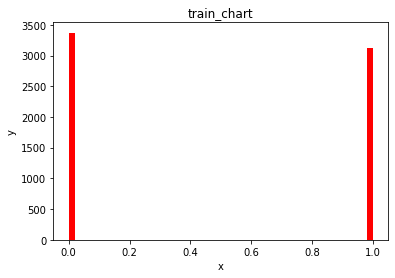

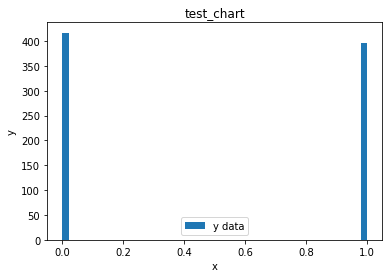

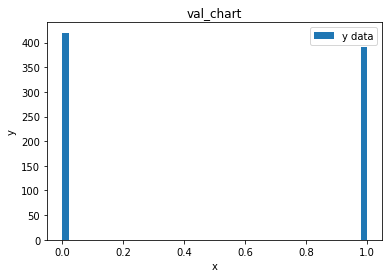

In [ ]:
#проверяем как распредлились значения в наборах, должно быть примерно по ровну, датасет сбалансирован
y_max=-999999999
y_min=999999999
count=0
count1=0
for i in range(y_train_class.shape[0]):
    if y_train_class[i]>y_max:
       y_max=y_train_class[i]
    if y_train_class[i]<y_min:
       y_min=y_train_class[i]
       
print(y_min)
print(y_max)

#график №1
plt.hist([y_train_class], 
         color="red",
         label='y data',
         range=(y_min,y_max), 
         bins=50) 
plt.xlabel("x") 
plt.ylabel("y") 
plt.title("train_chart" )
plt.show()

#график №2
plt.hist([y_test_class],# [Y_train,Y_test]
         range=(y_min,y_max), 
         label='y data',
         bins=50) 
plt.xlabel("x") 
plt.ylabel("y") 
plt.title("test_chart" )
plt.legend()
plt.show()

#график №3
plt.hist([y_val_class],# [Y_train,Y_test]
         range=(y_min,y_max), 
         label='y data',
         bins=50) 
plt.xlabel("x") 
plt.ylabel("y") 
plt.title("val_chart" )
plt.legend()
plt.show()
#отлично, примерно поровну 

# Создание и использование нейронной сети, оценка её работы и сохранение 

Тут я не стала придумывать свои теории и решила сразу придерживаться рекомендаций из лекций: 1) Для классификации подходят функции активации  relu, sigmoid, tanh (начала с relu если результат не устроит попробую другие). 2)Количество слоев не менее пяти 3) Дропаут 0.3  4) Для бинарной классификации хорош сигмоид (на выходе) 5)Алгоритм оптимизации попробовала Adam

С такими параметрами результат был хороший, уже на 4 эпохе обучения accuracy составило 100% и оказалось что менять параметры сети нет необходимости

In [ ]:
#создаем нейронную сеть

#инициализируем структуру модели
input_shape = (len(X_train_class[0]))
#input_shape = (x_row_len,)

model_in = Input(shape=input_shape)
dense0=Dense(64, activation="relu")(model_in) #описываем слои
dense1=Dense(128, activation="relu")(dense0)  #функции активации, которые хорошо работают в задачах классификации: relu, sigmoid, tanh
dense2=Dense(256, activation="relu")(dense1)
dense3=Dense(512, activation="relu")(dense2)
dropout0=Dropout(0.3)(dense3)
out=Dense(1, activation="sigmoid")(dropout0) #try sigmoid, tanh, relu and empty. you will see different results

#model=Model(model_in,out)# single input, single output
model=Model([model_in],[out])#один вход, один выход

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 22)]              0         
_________________________________________________________________
dense (Dense)                (None, 64)                1472      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_2 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_3 (Dense)              (None, 512)               131584    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                

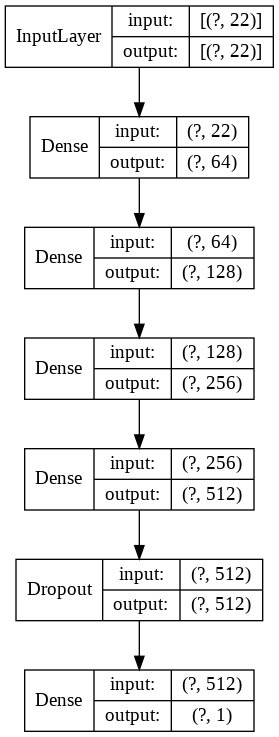

In [ ]:
#выбираем тренировочные параметы, компилируем модель
loss='binary_crossentropy'# функция потерь применяемая для бинарной классифкации - бинарная кросс-энтропия
#optimiser=optimizers.SGD(lr=0.01)
#optimiser=optimizers.RMSprop(lr=0.001)
optimiser=optimizers.Adam(lr=0.001) #указываем какой алгоритм оптимизации будем использовать

metrics1='accuracy'# выходные метрики
metrics2="mae"
model.compile(optimizer=optimiser, 
              loss=loss, 
              metrics=[metrics1, metrics2])
model.summary()
plot_model(model, to_file=folder+"/model_struct.png", expand_nested=True, show_shapes=True, show_layer_names=False) #отрисовываем схему модели

In [ ]:
#тренируем модель
callbacks = [
    ModelCheckpoint(folder+"/best_result_checkpoint", monitor='val_loss', save_best_only=True, verbose=0)
]


history = model.fit(X_train_class,
                    y_train_class, 
                    validation_data=(X_val_class, y_val_class),#X_test X_test_std X_test_norm
                    epochs=20,
                    batch_size=10,
                    callbacks=callbacks,
                    shuffle=True)

Epoch 1/20
634/650 [============================>.] - ETA: 0s - loss: 0.1385 - accuracy: 0.9426 - mae: 0.0831WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/training/tracking/tracking.py:111: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /content/gdrive/My Drive/грибы/best_result_checkpoint/assets
650/650 [==============================] - 3s 5ms/step - loss: 0.1381 - accuracy: 0.9425 - mae: 0.0827 - val_loss: 0.0737 - val_accuracy: 0.9803 - val_mae: 0.0244
Epoch 2/20
650/650 [==============================] - 3s 4ms/step - loss: 0.0266 - accuracy: 0.9928 - mae: 0.0124 - val_loss: 0.0121 - val_accuracy: 0.9963 - va

[0.1380568891763687, 0.02664583921432495, 0.018726609647274017, 0.0002506805758457631, 3.262926475144923e-05, 8.268903911812231e-06, 4.143822479818482e-06, 2.0853349269600585e-06, 1.7510697034595069e-06, 8.892344567357213e-07, 1.2198063359392108e-06, 6.394475349225104e-07, 0.03769683837890625, 0.00995337963104248, 0.008402449078857899, 4.299018837627955e-05, 1.039429844240658e-05, 2.683072807485587e-06, 1.670453912083758e-06, 1.1551140914889402e-06]


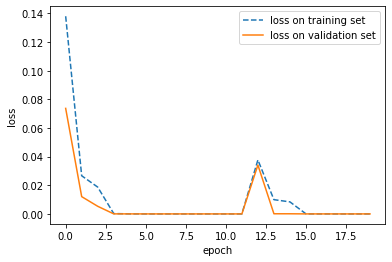

In [ ]:
#изменение значаения функции потерь в процессе тренировки
print(history.history['loss'])

plt.plot(history.history['loss'],'--', label='loss on training set')
plt.plot(history.history['val_loss'], label='loss on validation set')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.savefig(folder+"/loss.png")
plt.show()

[0.9424526691436768, 0.9927681088447571, 0.9944607019424438, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9907678365707397, 0.9966148734092712, 0.998153567314148, 1.0, 1.0, 1.0, 1.0, 1.0]


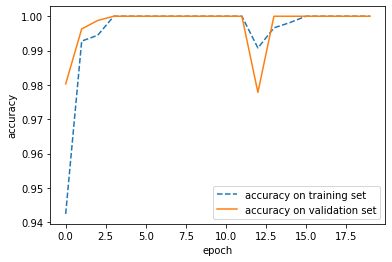

In [ ]:
#изменение значения точности в процессе тренировки
print(history.history['accuracy'])

plt.plot(history.history['accuracy'],'--', label='accuracy on training set')
plt.plot(history.history['val_accuracy'], label='accuracy on validation set')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.savefig(folder+"/accuracy.png")
plt.show()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 22)]              0         
_________________________________________________________________
dense (Dense)                (None, 64)                1472      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_2 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_3 (Dense)              (None, 512)               131584    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                

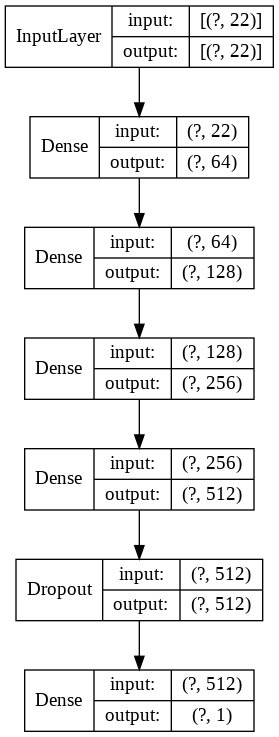

In [ ]:
#загрузка модели из чекпоинта
model=models.load_model(folder+"/best_result_checkpoint")
model.summary()
plot_model(model, to_file=folder+"/model_struct.png", expand_nested=True, show_shapes=True, show_layer_names=False)

In [ ]:
#оценка модели

loss, mae, mse = model.evaluate(X_train_class, y_train_class, verbose=2)# X_train X_train_std X_train_norm
print("-------------")
loss, mse, mae = model.evaluate(X_test_class, y_test_class, verbose=2)#X_test X_test_std X_test_norm
print("----------------")
loss, mse, mae = model.evaluate(X_val_class, y_val_class, verbose=2)#X_val X_val_std X_val_norm
print("----------------")

204/204 - 0s - loss: 2.0122e-07 - accuracy: 1.0000 - mean_absolute_error: 2.0019e-07
-------------
26/26 - 0s - loss: 4.1828e-05 - accuracy: 1.0000 - mean_absolute_error: 4.1127e-05
----------------
26/26 - 0s - loss: 6.0050e-07 - accuracy: 1.0000 - mean_absolute_error: 5.9982e-07
----------------


In [ ]:
#проверяем что предсказывает модель

pred = model.predict(X_test_class) 
for i in range(len(y_test_class)):
  print("предсказанное значение: "+str(pred[i][0])+" реальное значение: "+str(y_test_class[i]))   #если бы на выходе у нас было больше 1 нейрона, то писали бы pred[0][i][0] (первый 0 - номер выходного нейрона)

предсказанное значение: 3.9497176e-11 реальное значение: 0
предсказанное значение: 1.0 реальное значение: 1
предсказанное значение: 3.4865084e-24 реальное значение: 0
предсказанное значение: 1.0 реальное значение: 1
предсказанное значение: 1.0 реальное значение: 1
предсказанное значение: 1.0 реальное значение: 1
предсказанное значение: 1.0 реальное значение: 1
предсказанное значение: 8.6762284e-16 реальное значение: 0
предсказанное значение: 5.345204e-10 реальное значение: 0
предсказанное значение: 1.0 реальное значение: 1
предсказанное значение: 0.9999994 реальное значение: 1
предсказанное значение: 2.3177578e-09 реальное значение: 0
предсказанное значение: 1.0 реальное значение: 1
предсказанное значение: 1.0 реальное значение: 1
предсказанное значение: 1.0 реальное значение: 1
предсказанное значение: 1.0 реальное значение: 1
предсказанное значение: 1.0 реальное значение: 1
предсказанное значение: 1.2380389e-21 реальное значение: 0
предсказанное значение: 6.269973e-18 реальное значени

In [ ]:
#сохраняем модель
model_json = model.to_json()
json_file = open(folder+"/my_model" + ".json", "w")
#сохраняем структуру нейронной сети в формате JSON
json_file.write(model_json)
json_file.close()

# сохраняем веса нейронов в файл формата H5
model.save_weights(folder+"/my_model"+".h5")
print("saving done")

saving done


In [ ]:
#пусть полежит тут

model_json=folder+"/my_model.json"
model_h5=folder+"/my_model.h5"

#загрузка структуры
json_file = open(model_json, "r")
loaded_model_json = json_file.read()
json_file.close()

model2 = model_from_json(loaded_model_json)
# загрузка весов
model2.load_weights(model_h5)
print("Done")
model = Model(model2.input, model2.layers[-1].output)
model.trainable = True
# модель загружена
#далее нужно: выборать функции потерь, оптимизатора и метрики перед компиляцией модели
# и перейти в раздел выбора параметров обучения, затем компиляция.

Done


спасибо за обучение